<h1 ><big><center>Object recognition and computer vision 2020/2021</center></big></h1>

<h3><big><center><a href="http://www.di.ens.fr/~ponce/">Jean Ponce</a>, <a href="http://www.di.ens.fr/~laptev/">Ivan Laptev</a>, <a href="http://lear.inrialpes.fr/~schmid/">Cordelia Schmid</a> and <a href="http://www.di.ens.fr/~josef/">Josef Sivic</a></center></big></h3>

<h2><big><center> Assignment 2: Neural networks</center></big></h2>

<h5><big><center>Adapted from practicals from <a href="http://nicolas.le-roux.name/">Nicolas le Roux</a>, 
  <br><a href="http://www.robots.ox.ac.uk/~vgg/practicals/overview/index.html">Andrea Vedaldi and Andrew Zisserman</a> and <a href="https://cs.nyu.edu/~fergus/teaching/vision/">Rob Fergus</a>
  <br> by <a href="https://www.di.ens.fr/~varol/">Gul Varol</a> and <a href="https://www.di.ens.fr/~iroccosp/">Ignacio Rocco</a></center></big></h5>

</br>

<p align="center">
<img height=300px src="http://www.di.ens.fr/willow/teaching/recvis_orig/assignment3/images/fullyconn.png"/></p>
<p align="center">Figure 1</p>
<p align="center"></p>


**STUDENT**: Matias Etcheverry

**EMAIL**: matias.etcheverry9@gmail.com


# Guidelines

The purpose of this assignment is that you get hands-on experience with the topics covered in class, which will help you understand these topics better. Therefore, ** it is imperative that you do this assignment yourself. No code sharing will be tolerated. **

Once you have completed the assignment, you will submit the `ipynb` file containing **both** code and results. For this, make sure to **run your notebook completely before submitting**.

The `ipynb` must be named using the following format: **A2_LASTNAME_Firstname.ipynb**, and submitted in the **class Moodle page**.


# Goal


The goal of this assignment is to get basic knowledge and hands-on experience with training and using neural networks. In Part 1 of the assignment you will implement and experiment with the training and testing of a simple two layer fully-connected neural network, similar to the one depicted in Figure 1 above. In Part 2 you will learn about convolutional neural networks, their motivation, building blocks, and how they are trained. Finally, in part 3 you will train a CNN for classification using the CIFAR-10 dataset.


# Part 1 - Training a fully connected neural network


## Getting started


You will be working with a two layer neural network of the following form

\begin{equation}
H=\text{ReLU}(W_i X+B_i)\\
Y=W_oH+B_o
\tag{1}
\end{equation}

where $X$ is the input, $Y$ is the output, $H$ is the hidden layer, and $W_i$, $W_o$, $B_i$ and $B_o$ are the network parameters that need to be trained. Here the subscripts $i$ and $o$ stand for the _input_ and _output_ layer, respectively. This network was also discussed in the class and is illustrated in the above figure where the input units are shown in green, the hidden units in blue and the output in yellow. This network is implemented in the function `nnet_forward_logloss`.

You will train the parameters of the network from labelled training data $\{X^n,Y^n\}$ where $X^n$ are points in $\mathbb{R}^2$ and $Y^n\in\{-1,1\}$ are labels for each point. You will use the stochastic gradient descent algorithm discussed in the class to minimize the loss of the network on the training data given by

\begin{equation}
L=\ s(Y^n,\bar{Y}(X^n))
\tag{2}
\end{equation}

where $Y^n$ is the target label for the n-th example and $\bar{Y}(X^n)$ is the network’s output for the n-th example $X^n$. The skeleton of the training procedure is provided in the `train_loop` function.

We will use the logistic loss, which has the following form:

\begin{equation}
s(Y, \bar{Y}(X))=\log(1+\exp(-Y. \bar{Y}(X))
\tag{3}
\end{equation}

where $Y$ is the target label and $\bar{Y}(X)$ is the output of the network for input example $X$. With the logistic loss, the output of the network can be interpreted as a probability $P(\text{class}=1|X) =\sigma(X)$ , where $\sigma(X) =1/(1+\exp(-X))$ is the sigmoid function. Note also that $P(\text{class}=-1|X)=1-P(\text{class}=1|X)$.


In [1]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio


def decision_boundary_nnet(X, Y, Wi, bi, Wo, bo):
    x_min, x_max = -2, 4
    y_min, y_max = -5, 3
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .05),
                     np.arange(y_min, y_max, .05))

    XX = np.vstack((xx.ravel(), yy.ravel())).T
    input_hidden = np.dot(XX, Wi) + bi
    hidden = np.maximum(input_hidden, 0)
    Z = np.dot(hidden, Wo) + bo

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z > 0, cmap=plt.cm.Paired)
    plt.axis('off')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='winter')
    plt.axis([-2, 4, -5, 3])
    plt.draw()


def sigm(x):
    # Returns the sigmoid of x.
    small_x = np.where(x < -20)  # Avoid overflows.
    sigm_x = 1/(1 + np.exp(-x))
    if type(sigm_x) is np.ndarray:
        sigm_x[small_x] = 0.0
    return sigm_x


def nnet_forward_logloss(X, Y, Wi, bi, Wo, bo):
    '''
    Compute the output Po, Yo and the loss of the network for the input X
    This is a 2 layer (1 hidden layer network)

    Input:
        X ... (in R^2) set of input points, one per column
        Y ... {-1,1} the target values for the set of points X
        Wi, bi, Wo, bo ... parameters of the network

    Output: 
       Po ... probabilisitc output of the network P(class=1 | x) 
                  Po is in <0 1>. 
                  Note: P(class=-1 | x ) = 1 - Po
       Yo ... output of the network Yo is in <-inf +inf>
       loss ... logistic loss of the network on examples X with ground target
                    values Y in {-1,1}
    '''
    # Hidden layer
    hidden = np.maximum(np.dot(X, Wi) + bi, 0)
    # Output of the network
    Yo = np.dot(hidden, Wo) + bo
    # Probabilistic output
    Po = sigm(Yo)
    # Logistic loss
    loss = np.log(1 + np.exp( -Y * Yo)) 
    return Po, Yo, loss


# Load the training data
!wget -q http://www.di.ens.fr/willow/teaching/recvis_orig/assignment2/double_moon_train1000.mat
train_data = sio.loadmat('./double_moon_train1000.mat', squeeze_me=True)
Xtr = train_data['X']
Ytr = train_data['Y']
# Load the validation data
!wget -q http://www.di.ens.fr/willow/teaching/recvis_orig/assignment2/double_moon_val1000.mat
val_data = sio.loadmat('./double_moon_val1000.mat', squeeze_me=True)
Xval = val_data['X']
Yval = val_data['Y']

## Computing gradients of the loss with respect to network parameters


### :: TASK 1.1 ::

Derive the form of the gradient of the logistic loss (3) with respect to the parameters of the network $W_i$, $W_o$, $B_i$ and $B_o$. _Hint:_ Use the chain rule as discussed in the class.


We will compute the gradient of the logistic loss wrt to the network's parameters.

$$
\begin{align}
H &= ReLU(W_I X + B_I) \\
\bar{Y} &= W_0 H + B_0 \\
s(Y, \bar{Y}(X)) & = log(1+\exp(-Y. \bar{Y}(X)) \\
\end{align}
$$

Thus, on the output layer, we have

$$
\begin{align}
\frac{\partial s}{\partial W_O}(Y^n, \bar{Y^n}) =\frac{-Y^nH e^{-Y^n(W_OH+B_O)}}{1+e^{-Y^n(W_OH+B_O)}}\\
ie \quad \boxed{\frac{\partial s}{\partial W_O}(Y^n, \bar{Y^n}) =\frac{-Y^nH}{1+e^{Y^n\bar{Y}^n}}}\\
\end{align}
$$

$$
\begin{align}
\frac{\partial s}{\partial B_O}(Y^n, \bar{Y^n}) =\frac{-Y^n e^{-Y^n(W_OH+B_O)}}{1+e^{-Y^n(W_OH+B_O)}}\\
ie  \quad \boxed{\frac{\partial s}{\partial B_O}(Y^n, \bar{Y^n})  =\frac{-Y^n}{1+e^{Y^n\bar{Y}^n}}}\\
\end{align}
$$

Thus, on the input layer, we have,

$$
\begin{align}
\frac{\partial s}{\partial W_I}(Y^n, \bar{Y^n}) & = \frac{\partial s}{\partial H}\frac{\partial H}{\partial W_I}(Y^n, \bar{Y^n}) & \text{(chained rule)}\\
& =\frac{-Y^nW_O}{1+e^{Y^n\bar{Y}^n}} \times \frac{\partial max(W_IX^n+B_I, 0)}{\partial W_I} & \\
\end{align}
$$

$$
\begin{align}
ie \quad \boxed{\frac{\partial s}{\partial W_I}(Y^n, \bar{Y^n}) =
\begin{cases}
   \frac{-Y^nW_O {X^n}^T}{1+e^{Y^n\bar{Y}^n}}, & \text{if } W_IX^n+B_I \geq 0\\
    0,              & \text{otherwise}
\end{cases}
}
\end{align}
$$

$$
\begin{align}
\frac{\partial s}{\partial B_I}(Y^n, \bar{Y^n}) & = \frac{\partial s}{\partial H}\frac{\partial H}{\partial B_I}(Y^n, \bar{Y^n}) & \text{(chained rule)}\\
& =\frac{-Y^nW_O}{1+e^{Y^n\bar{Y}^n}} \times \frac{\partial max(W_IX^n+B_I, 0)}{\partial B_I} & \\
\end{align}
$$

$$
\begin{align}
ie \quad \boxed{\frac{\partial s}{\partial B_I}(Y^n, \bar{Y^n}) =
\begin{cases}
   \frac{-Y^nW_O}{1+e^{Y^n\bar{Y}^n}}, & \text{if } W_IX^n+B_I \geq 0\\
    0,              & \text{otherwise}
\end{cases}
}
\end{align}
$$


### :: TASK 1.2 ::

Following your derivation, implement the gradient computation in the function `gradient_nn`. See the code for the description of the required inputs / outputs of this function.


In [2]:
def gradient_nn(X, Y, Wi, bi, Wo, bo):
    """
    Compute gradient of the logistic loss of the neural network on example X with
    target label Y, with respect to the parameters Wi,bi,Wo,bo.

    Input:
        X ... 2d vector of the input example
        Y ... the target label in {-1,1}
        Wi,bi,Wo,bo ... parameters of the network
        Wi ... [dxh]
        bi ... [h]
        Wo ... [h]
        bo ... 1
        where h... is the number of hidden units
              d... is the number of input dimensions (d=2)

    Output:
        grad_s_Wi [dxh] ... gradient of loss s(Y,Y(X)) w.r.t  Wi
        grad_s_bi [h]   ... gradient of loss s(Y,Y(X)) w.r.t. bi
        grad_s_Wo [h]   ... gradient of loss s(Y,Y(X)) w.r.t. Wo
        grad_s_bo 1     ... gradient of loss s(Y,Y(X)) w.r.t. bo
    """
    ##########################
    hidden = np.maximum(np.dot(X, Wi) + bi, 0)
    Yo = np.dot(hidden, Wo) + bo
    denominator = 1 + np.exp(Y * Yo)
    above_0 = np.array(np.dot(X, Wi) + bi > 0, dtype=bool)

    grad_s_Wo = -(Y * hidden) / denominator
    grad_s_bo = -Y / denominator
    grad_s_Wi = (
        -(Y * (np.expand_dims(X, 1) @ np.expand_dims(Wo, 1).T) * above_0) / denominator
    )
    grad_s_bi = -(Y * Wo * above_0) / denominator
    return (
        grad_s_Wi,
        grad_s_bi,
        grad_s_Wo,
        grad_s_bo,
    )
    ##########################

## Numerically verify the gradients

Here you will numerically verify that your analytically computed gradients in function `gradient_nn` are correct.


### :: TASK 1.3 ::

Write down the general formula for numerically computing the approximate derivative of the loss $s(\theta)$, with respect to the parameter $\theta_i$ using finite differencing. _Hint: use the first order Taylor expansion of loss $s(\theta+\Delta \theta)$ around point $\theta$. _


General case:

Let $s$ a continuous function around $\theta$, then

\begin{align}
\frac{\partial s}{\partial \theta} = \frac{s(\theta + \Delta\theta) - s(\theta - \Delta\theta)}{2\Delta\theta}
\end{align}

Thus, when applying this on the network's parameters:

\begin{align}
\boxed{\frac{\partial s}{\partial W_0} = \frac{s(W_0 + \Delta W_0) - s(W_0 - \Delta W_0)}{2\Delta W_0}}\\
\boxed{\frac{\partial s}{\partial B_0} = \frac{s(B_0 + \Delta B_0) - s(B_0 - \Delta B_0)}{2\Delta B_0}}\\
\boxed{\frac{\partial s}{\partial W_I} = \frac{s(W_I + \Delta W_I) - s(W_I - \Delta W_I)}{2\Delta W_I}}\\
\boxed{\frac{\partial s}{\partial B_I} = \frac{s(B_I + \Delta B_I) - s(B_I - \Delta B_I)}{2\Delta B_I}}\\
\end{align}

Note: with the right dimensions, we can choose $\Delta W_0 = \Delta B_0 = \Delta W_I = \Delta B_I = \epsilon$


Following the general formula, `gradient_nn_numerical` function numerically computes the derivatives of the loss function with respect to all the parameters of the network $W_i$, $W_o$, $B_i$ and $B_o$:


In [3]:
def gradient_nn_numerical(X, Y, Wi, bi, Wo, bo):
    """
    Compute numerical gradient of the logistic loss of the neural network on
    example X with target label Y, with respect to the parameters Wi,bi,Wo,bo.

    Input:
       X ... 2d vector of the input example
       Y ... the target label in {-1,1}
       Wi, bi, Wo, bo ... parameters of the network
       Wi ... [dxh]
       bi ... [h]
       Wo ... [h]
       bo ... 1
       where h... is the number of hidden units
             d... is the number of input dimensions (d=2)

    Output:
       grad_s_Wi_numerical [dxh] ... gradient of loss s(Y,Y(X)) w.r.t  Wi
       grad_s_bi_numerical [h]   ... gradient of loss s(Y,Y(X)) w.r.t. bi
       grad_s_Wo_numerical [h]   ... gradient of loss s(Y,Y(X)) w.r.t. Wo
       grad_s_bo_numerical 1     ... gradient of loss s(Y,Y(X)) w.r.t. bo
    """

    eps = 1e-8
    grad_s_Wi_numerical = np.zeros(Wi.shape)
    grad_s_bi_numerical = np.zeros(bi.shape)
    grad_s_Wo_numerical = np.zeros(Wo.shape)

    for i in range(Wi.shape[0]):
        for j in range(Wi.shape[1]):
            dummy, dummy, pos_loss = nnet_forward_logloss(
                X, Y, sumelement_matrix(Wi, i, j, +eps), bi, Wo, bo
            )
            dummy, dummy, neg_loss = nnet_forward_logloss(
                X, Y, sumelement_matrix(Wi, i, j, -eps), bi, Wo, bo
            )
            grad_s_Wi_numerical[i, j] = (pos_loss - neg_loss) / (2 * eps)

    for i in range(bi.shape[0]):
        dummy, dummy, pos_loss = nnet_forward_logloss(
            X, Y, Wi, sumelement_vector(bi, i, +eps), Wo, bo
        )
        dummy, dummy, neg_loss = nnet_forward_logloss(
            X, Y, Wi, sumelement_vector(bi, i, -eps), Wo, bo
        )
        grad_s_bi_numerical[i] = (pos_loss - neg_loss) / (2 * eps)

    for i in range(Wo.shape[0]):
        dummy, dummy, pos_loss = nnet_forward_logloss(
            X, Y, Wi, bi, sumelement_vector(Wo, i, +eps), bo
        )
        dummy, dummy, neg_loss = nnet_forward_logloss(
            X, Y, Wi, bi, sumelement_vector(Wo, i, -eps), bo
        )
        grad_s_Wo_numerical[i] = (pos_loss - neg_loss) / (2 * eps)

    dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, Wi, bi, Wo, bo + eps)
    dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, Wi, bi, Wo, bo - eps)
    grad_s_bo_numerical = (pos_loss - neg_loss) / (2 * eps)

    return (
        grad_s_Wi_numerical,
        grad_s_bi_numerical,
        grad_s_Wo_numerical,
        grad_s_bo_numerical,
    )


def sumelement_matrix(X, i, j, element):
    Y = np.copy(X)
    Y[i, j] = X[i, j] + element
    return Y


def sumelement_vector(X, i, element):
    Y = np.copy(X)
    Y[i] = X[i] + element
    return Y


### :: TASK 1.4 ::

Run the following code snippet and understand what it is doing. `gradcheck` function checks that the analytically computed derivative using function `gradient_nn` (e.g. `grad_s_bo`) at the same training example $\{X,Y\}$ is the same (up to small errors) as your numerically computed value of the derivative using function `gradient_nn_numerical` (e.g. `grad_s_bo_numerical`). Make sure the output is `SUCCESS` to move on to the next task.


In [4]:
def gradcheck():
    """
    Check that the numerical and analytical gradients are the same up to eps
    """
    h = 3  # number of hidden units
    eps = 1e-6
    for i in range(1000):
        # Generate random input/output/weight/bias
        X = np.random.randn(2)
        Y = 2 * np.random.randint(2) - 1  # {-1, 1}
        Wi = np.random.randn(X.shape[0], h)
        bi = np.random.randn(h)
        Wo = np.random.randn(h)
        bo = np.random.randn(1)
        # Compute analytical gradients
        grad_s_Wi, grad_s_bi, grad_s_Wo, grad_s_bo = gradient_nn(X, Y, Wi, bi, Wo, bo)
        # Compute numerical gradients
        (
            grad_s_Wi_numerical,
            grad_s_bi_numerical,
            grad_s_Wo_numerical,
            grad_s_bo_numerical,
        ) = gradient_nn_numerical(X, Y, Wi, bi, Wo, bo)
        # Compute the difference between analytical and numerical gradients
        Delta_Wi = np.mean(np.abs(grad_s_Wi - grad_s_Wi_numerical))
        Delta_bi = np.mean(np.abs(grad_s_bi - grad_s_bi_numerical))
        Delta_Wo = np.mean(np.abs(grad_s_Wo - grad_s_Wo_numerical))
        Delta_bo = np.abs(grad_s_bo - grad_s_bo_numerical)
        # Difference larger than a threshold
        if Delta_Wi > eps or Delta_bi > eps or Delta_Wo > eps or Delta_bo > eps:
            return False

    return True


# Check gradients
if gradcheck():
    print("SUCCESS: Passed gradcheck.")
else:
    print("FAILURE: Fix gradient_nn and/or gradient_nn_aprox implementation.")


SUCCESS: Passed gradcheck.


## Training the network using backpropagation and experimenting with different parameters


Use the provided code below that calls the `train_loop` function. Set the number of hidden units to 7 by setting $h=7$ in the code and set the learning rate to 0.02 by setting `lrate = 0.02`. Run the training code. Visualize the trained hyperplane using the provided function `plot_decision_boundary(Xtr,Ytr,Wi,bi,Wo,bo)`. Show also the evolution of the training and validation errors. Include the decision hyper-plane visualization and the training and validation error plots.


In [5]:
def train_loop(Xtr, Ytr, Xval, Yval, h, lrate, vis="all", nEpochs=100):
    """
    Check that the numerical and analytical gradients are the same up to eps

    Input:
        Xtr ... Nx2 matrix of training samples
        Ytr ... N dimensional vector of training labels
        Xval ... Nx2 matrix of validation samples
        Yval ... N dimensional vector validation labels
        h ... number of hidden units
        lrate ... learning rate
        vis ... visulaization option ('all' | 'last' | 'never')
        nEpochs ... number of training epochs

    Output:
        tr_error ... nEpochs*nSamples dimensional vector of training error
        val_error ... nEpochs*nSamples dimensional vector of validation error
    """

    nSamples = Xtr.shape[0]
    tr_error = np.zeros(nEpochs * nSamples)
    val_error = np.zeros(nEpochs * nSamples)

    # Randomly initialize parameters of the model
    Wi = np.random.randn(Xtr.shape[1], h)
    Wo = np.zeros(h)
    bi = np.zeros(h)
    bo = 0.0

    if vis == "all" or vis == "last":
        plt.figure()

    for i in range(nEpochs * nSamples):
        # Draw an example at random
        n = np.random.randint(nSamples)
        X = Xtr[n]
        Y = Ytr[n]

        # Compute gradient
        grad_s_Wi, grad_s_bi, grad_s_Wo, grad_s_bo = gradient_nn(X, Y, Wi, bi, Wo, bo)

        # Gradient update
        Wi -= lrate * grad_s_Wi
        Wo -= lrate * grad_s_Wo
        bi -= lrate * grad_s_bi
        bo -= lrate * grad_s_bo

        # Compute training error
        Po, Yo, loss = nnet_forward_logloss(Xtr, Ytr, Wi, bi, Wo, bo)
        Yo_class = np.sign(Yo)
        tr_error[i] = 100 * np.mean(Yo_class != Ytr)

        # Compute validation error
        Pov, Yov, lossv = nnet_forward_logloss(Xval, Yval, Wi, bi, Wo, bo)
        Yov_class = np.sign(Yov)
        val_error[i] = 100 * np.mean(Yov_class != Yval)

        # Plot (at every epoch if visualization is 'all', only at the end if 'last')
        if (vis == "all" and i % nSamples == 0) or (
            vis == "last" and i == nEpochs * nSamples - 1
        ):
            # Draw the decision boundary.
            plt.clf()
            plt.title(
                "p = %d, Iteration = %.d, Error = %.3f" % (h, i / nSamples, tr_error[i])
            )
            decision_boundary_nnet(Xtr, Ytr, Wi, bi, Wo, bo)
            display.display(plt.gcf(), display_id=True)
            display.clear_output(wait=True)

    if vis == "all":
        # Plot the evolution of the training and test errors
        plt.figure()
        plt.plot(tr_error, label="training")
        plt.plot(val_error, label="validation")
        plt.legend()
        plt.title(
            "Training/validation errors: %.2f%% / %.2f%%"
            % (tr_error[-1], val_error[-1])
        )
    return tr_error, val_error


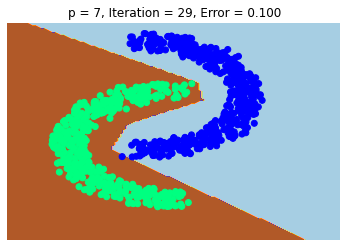

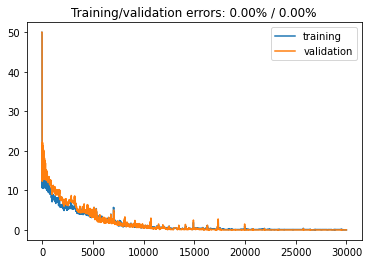

In [6]:
# Run training
h = 7
lrate = 0.02
tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate, nEpochs=30)


### :: TASK 1.6 ::

**Random initializations.** Repeat this procedure 5 times from 5 different random initializations. Record for each run the final training and validation errors. Did the network always converge to zero training error? Summarize your final training and validation errors into a table for the 5 runs. You do not need to include the decision hyper-plane visualizations. Note: to speed-up the training you can plot the visualization figures less often (or never) and hence speed-up the training.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


100%|██████████| 5/5 [03:01<00:00, 36.21s/it]


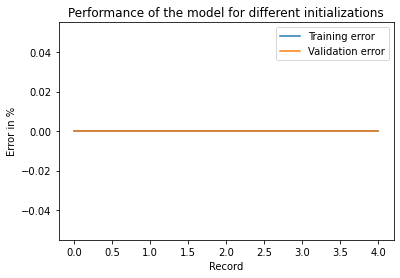

In [7]:
##########################
%pip install tqdm
from tqdm import trange 
import matplotlib.pyplot as plt

h = 7
lrate = 0.02
tr_errors = []
val_errors = []
for i in trange(5):
    tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate, vis="never", nEpochs=100)
    tr_errors.append(tr_error[-1])
    val_errors.append(val_error[-1])

plt.plot(tr_errors, label="Training error")
plt.plot(val_errors, label="Validation error")
plt.ylabel("Error in %")
plt.xlabel("Record")
plt.title("Performance of the model for different initializations")
plt.legend()
plt.show()
##########################

Here are the differents errors I obtained on 5 different initializations:

| Error            | Record N°1 | N°2 | N°3 | N°4 | N°5 |
| ---------------- | ---------- | --- | --- | --- | --- |
| Training Error   | 0          | 0   | 0   | 0   | 0   |
| Validation Error | 0          | 0   | 0   | 0   | 0   |

The training and the validation errors always converge to 0. However, the models don't always converge to the same value.


### :: SAMPLE TASK ::

For this task, the answer is given. Run the given code and answer Task 1.8 similarly.

**Learning rate:**

Keep $h=7$ and change the learning rate to values $\text{lrate} = \{2, 0.2, 0.02, 0.002\}$. For each of these values run the training procedure 5 times and observe the training behaviour. You do not need to include the decision hyper-plane visualizations in your answer.

**- Make one figure** where _final_ error for (i) training and (ii) validation sets are superimposed. $x$-axis should be the different values of the learning rate, $y$-axis the error _mean_ across 5 runs. Show the standard deviation with error bars and make sure to label each plot with a legend.

**- Make another figure** where _training error evolution_ for each learning rate is superimposed. $x$-axis should be the iteration number, $y$-axis the training error _mean_ across 5 runs for a given learning rate. Show the standard deviation with error bars and make sure to label each curve with a legend.


In [8]:
nEpochs = 40
trials = 5
lrates = [2, 0.2, 0.02, 0.002]
plot_data_lr = np.zeros((2, trials, len(lrates), nEpochs * 1000))
h = 7
for j, lrate in enumerate(lrates):
    print("LR = %f" % lrate)
    for i in range(trials):
        tr_error, val_error = train_loop(
            Xtr, Ytr, Xval, Yval, h, lrate, vis="never", nEpochs=nEpochs
        )
        plot_data_lr[0, i, j, :] = tr_error
        plot_data_lr[1, i, j, :] = val_error


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


LR = 2.000000
LR = 0.200000
LR = 0.020000
LR = 0.002000


Text(0, 0.5, 'training error')

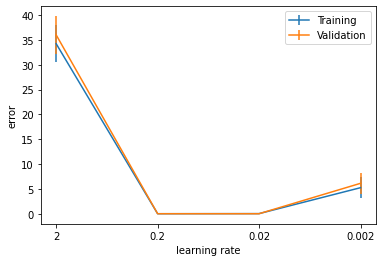

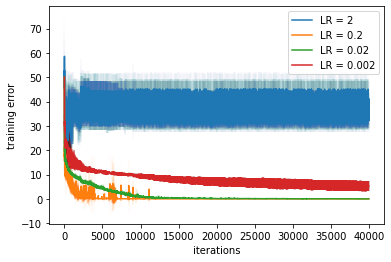

In [9]:
plt.errorbar(
    np.arange(len(lrates)),
    plot_data_lr[0, :, :, -1].mean(axis=0),
    yerr=plot_data_lr[0, :, :, -1].std(axis=0),
    label="Training",
)
plt.errorbar(
    np.arange(len(lrates)),
    plot_data_lr[1, :, :, -1].mean(axis=0),
    yerr=plot_data_lr[0, :, :, -1].std(axis=0),
    label="Validation",
)
plt.xticks(np.arange(len(lrates)), lrates)
plt.xlabel("learning rate")
plt.ylabel("error")
plt.legend()

# Plot the evolution of the training loss for each learning rate
plt.figure()
for j, lrate in enumerate(lrates):
    x = np.arange(plot_data_lr.shape[3])
    # Mean training loss over trials
    y = plot_data_lr[0, :, j, :].mean(axis=0)
    # Standard deviation over trials
    ebar = plot_data_lr[0, :, j, :].std(axis=0)
    # Plot
    markers, caps, bars = plt.errorbar(x, y, yerr=ebar, label="LR = " + str(lrate))
    # Make the error bars transparent
    [bar.set_alpha(0.01) for bar in bars]
plt.legend()
plt.xlabel("iterations")
plt.ylabel("training error")


### :: TASK 1.7 ::

**- Briefly discuss** the different behaviour of the training for different learning rates. How many iterations does it take to converge or does it converge at all? Which learning rate is better and why?


##########################

We can see that the results are really different from a training to another:

- for a learning rate $=2$ the model didn't converge at all. The results highly oscillate. The learning rate is to big to find a minimum in the loss
- for a learning rate $=0.2$, the is the model that converges the fastest. It reaches the optimal value from the $2500^{th}$ iterations ($\approx 3$ epochs). However, the model is still very unstable, and the results change a lot. This model is unpredictable when it just has converged
- for a learning rate $=0.02$, the model is the best. It slowly converges towards the same value as before, but the curve is clean without outliers. It reaches the optimal value fro the $1750^{th}$ iteration ($\approx 2$ epochs) and doesn't leave it after.
- for a learning rate $=0.002$, the model doesn't converge in less than $4000$ iterations. The model will probably converge after, in a dozen of epochs. This model would lead to good result in a longer training, but requires too much time, and thus, too much computational power. Moreover, the standard deviation is much higher than with other models.

The best model so far is obtained with a learning rate at $0.02$.

##########################


### :: TASK 1.8 ::

**The number of hidden units:**

Set the learning rate to 0.02 and change the number of hidden units $h = \{1, 2, 5, 7, 10, 100\}$. For each of these values run the training procedure 5 times and observe the training behaviour

**-Visualize** one decision hyper-plane per number of hidden units.

**-Make one figure** where _final_ error for (i) training and (ii) validation sets are superimposed. $x$-axis should be the different values of the number of hidden units, $y$-axis the error _mean_ across 5 runs. Show the standard deviation with error bars and make sure to label each plot with a legend.

**-Make another figure** where _training error evolution_ for each number of hidden units is superimposed. $x$-axis should be the iteration number, $y$-axis the training error _mean_ across 5 runs for a given learning rate. Show the standard deviation with error bars and make sure to label each curve with a legend.

**-Briefly discuss** the different behaviours for the different numbers of hidden units.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Text(0, 0.5, 'training error')

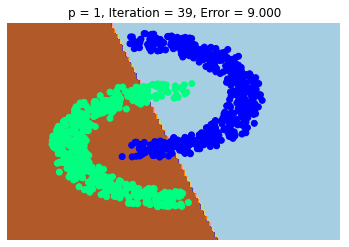

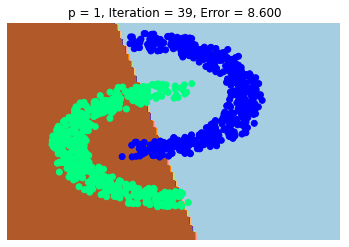

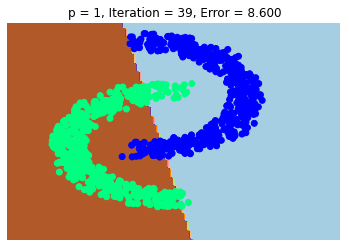

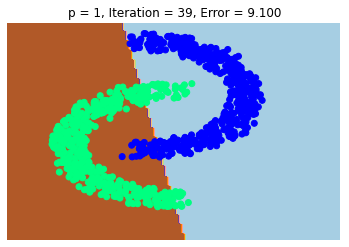

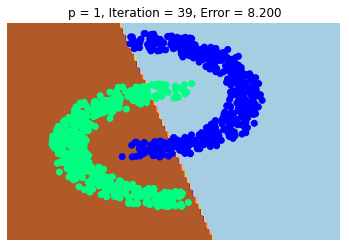

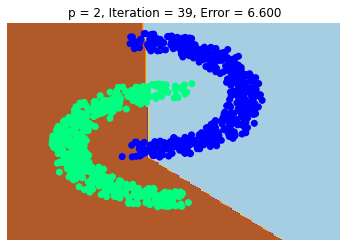

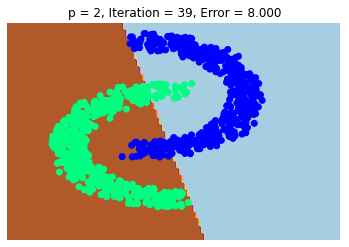

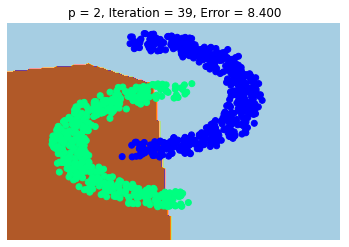

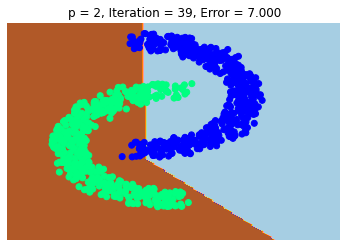

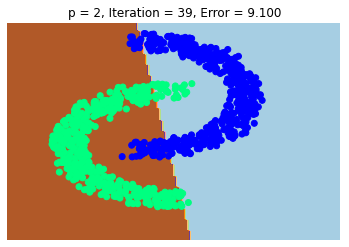

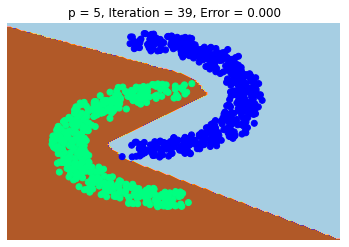

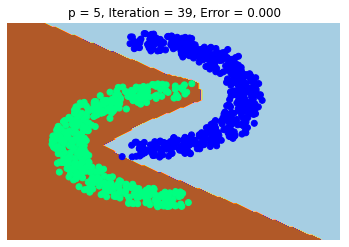

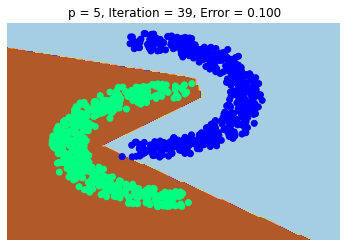

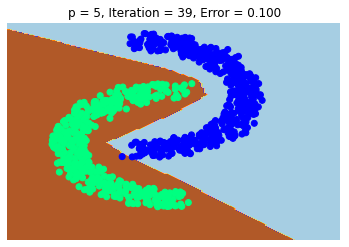

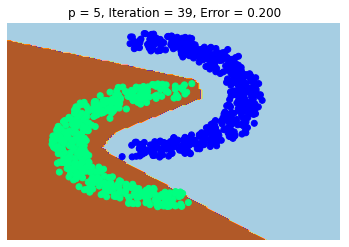

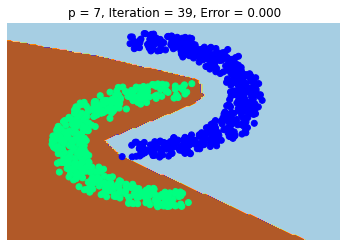

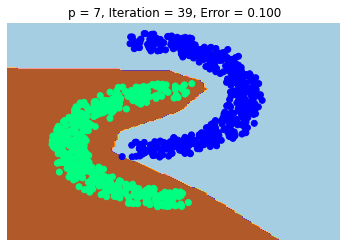

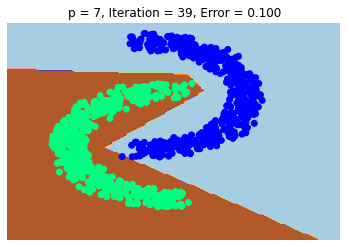

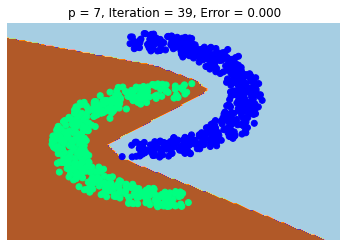

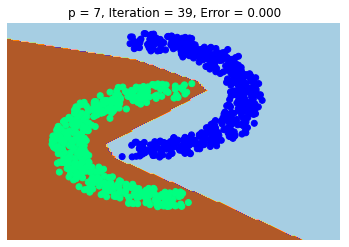

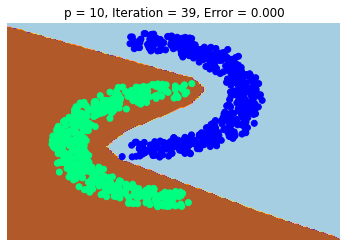

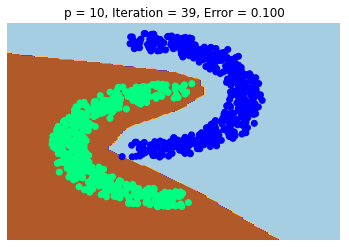

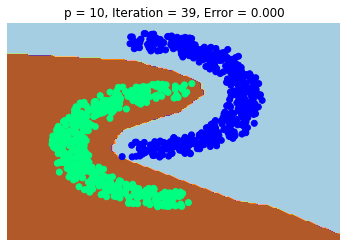

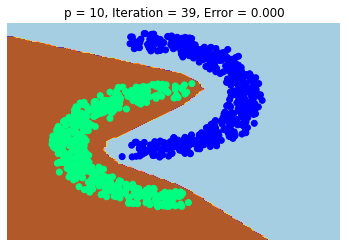

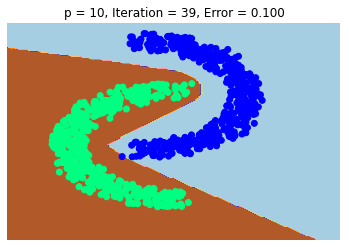

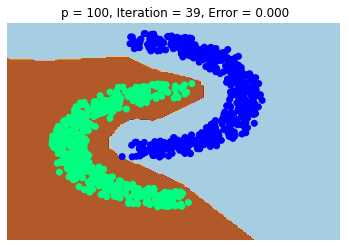

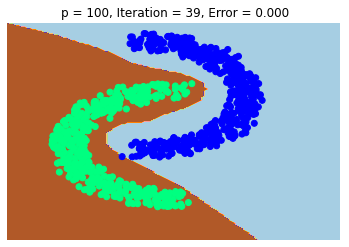

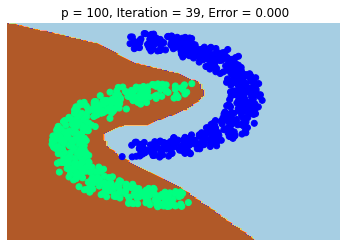

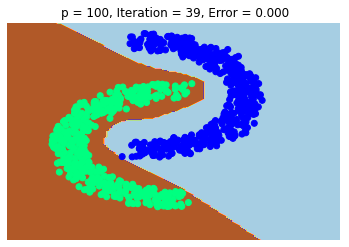

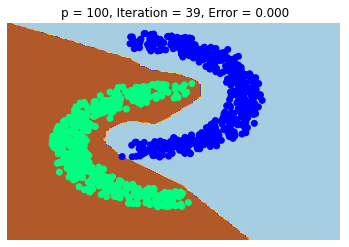

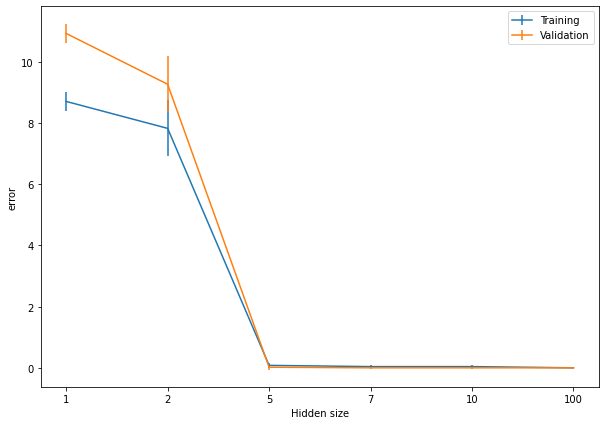

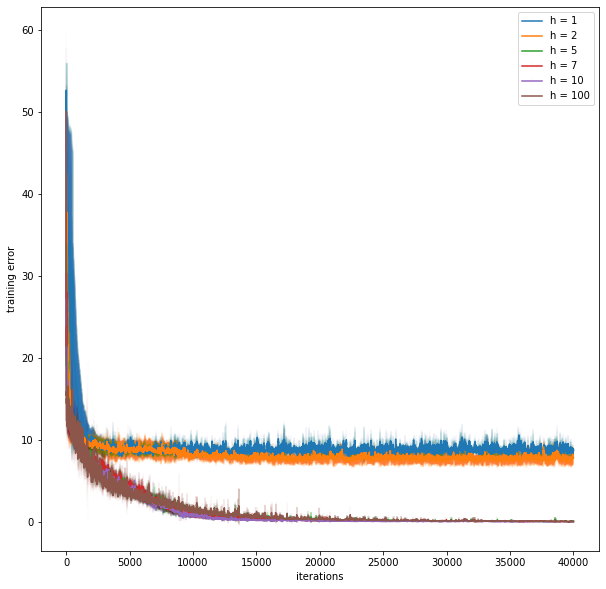

In [10]:
##########################

nEpochs = 40
trials = 5
lrate = 0.02
hidden_sizes = [1, 2, 5, 7, 10, 100]
plot_data_h = np.zeros((2, trials, len(hidden_sizes), nEpochs * 1000))
for j, h in enumerate(hidden_sizes):
    print("Hidden Size = %f" % h)
    for i in range(trials):
        tr_error, val_error = train_loop(
            Xtr, Ytr, Xval, Yval, h, lrate, vis="last", nEpochs=nEpochs
        )
        plot_data_h[0, i, j, :] = tr_error
        plot_data_h[1, i, j, :] = val_error

plt.figure(figsize=(10, 7))
plt.errorbar(
    np.arange(len(hidden_sizes)),
    plot_data_h[0, :, :, -1].mean(axis=0),
    yerr=plot_data_h[0, :, :, -1].std(axis=0),
    label="Training",
)
plt.errorbar(
    np.arange(len(hidden_sizes)),
    plot_data_h[1, :, :, -1].mean(axis=0),
    yerr=plot_data_h[0, :, :, -1].std(axis=0),
    label="Validation",
)
plt.xticks(np.arange(len(hidden_sizes)), hidden_sizes)
plt.xlabel("Hidden size")
plt.ylabel("error")
plt.legend()

# Plot the evolution of the training loss for each learning rate
plt.figure(figsize=(10, 10))
for j, h in enumerate(hidden_sizes):
    x = np.arange(plot_data_h.shape[3])
    # Mean training loss over trials
    y = plot_data_h[0, :, j, :].mean(axis=0)
    # Standard deviation over trials
    ebar = plot_data_h[0, :, j, :].std(axis=0)
    # Plot
    markers, caps, bars = plt.errorbar(x, y, yerr=ebar, label="h = " + str(h))
    # Make the error bars transparent
    [bar.set_alpha(0.01) for bar in bars]
plt.legend()
plt.xlabel("iterations")
plt.ylabel("training error")

##########################

##########################

We globally notice that the error is a decreasing function with respect to the hidden size.

Indeed, for a hidden size in [1, 2], the model is too lightweight and can't understand the complexity of the data. We are underfitting.
For a hidden size inn [5, 7, 10, 100], the model is much stronger. However, the training time is also an increasing function with respect to the hidden size.
We also notice that for 5 hidden neurons, the result is highly unstable.

There is a trade off between convergence and training time. Thus, this leads us to conclude that the best value of the hidden size hyperparameter are 7 or 10.

##########################


# Part 2 - Building blocks of a CNN

This part introduces typical CNN building blocks, such as ReLU units and linear filters. For a motivation for using CNNs over fully-connected neural networks, see [[Le Cun, et al, 1998]](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).


## Install PyTorch


In [11]:
!pip install torch torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
1.12.1+cu113
True


## Convolution

A feed-forward neural network can be thought of as the composition of number of functions

$$
f(\mathbf{x}) = f_L(\dots f_2(f_1(\mathbf{x};\mathbf{w}_1);\mathbf{w}_2)\dots),\mathbf{w}_{L}).
$$

Each function $f_l$ takes as input a datum $\mathbf{x}_l$ and a parameter vector $\mathbf{w}_l$ and produces as output a datum $\mathbf{x}_{l+1}$. While the type and sequence of functions is usually handcrafted, the parameters $\mathbf{w}=(\mathbf{w}_1,\dots,\mathbf{w}_L)$ are _learned from data_ in order to solve a target problem, for example classifying images or sounds.

In a _convolutional neural network_ data and functions have additional structure. The data $\mathbf{x}_1,\dots,\mathbf{x}_n$ are images, sounds, or more in general maps from a lattice$^1$ to one or more real numbers. In particular, since the rest of the practical will focus on computer vision applications, data will be 2D arrays of pixels. Formally, each $\mathbf{x}_i$ will be a $M \times N \times K$ real array of $M \times N$ pixels and $K$ channels per pixel. Hence the first two dimensions of the array span space, while the last one spans channels. Note that only the input $\mathbf{x}=\mathbf{x}_1$ of the network is an actual image, while the remaining data are intermediate _feature maps_.

The second property of a CNN is that the functions $f_l$ have a _convolutional structure_. This means that $f_l$ applies to the input map $\mathbf{x}_l$ an operator that is _local and translation invariant_. Examples of convolutional operators are applying a bank of linear filters to $\mathbf{x}_l$.

In this part we will familiarise ourselves with a number of such convolutional and non-linear operators. The first one is the regular _linear convolution_ by a filter bank. We will start by focusing our attention on a single function relation as follows:

$$
 f: \mathbb{R}^{M\times N\times K} \rightarrow \mathbb{R}^{M' \times N' \times K'},
 \qquad \mathbf{x} \mapsto \mathbf{y}.
$$

$^1$A two-dimensional _lattice_ is a discrete grid embedded in $R^2$, similar for example to a checkerboard.


(384, 512, 3)


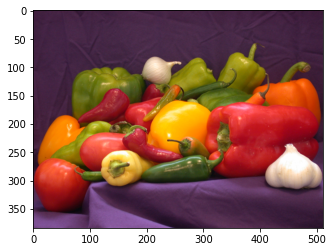

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Download an example image
!wget -q http://www.di.ens.fr/willow/teaching/recvis_orig/assignment3/images/peppers.png
# Read the image 
x = np.asarray(Image.open('peppers.png'))/255.0
# Print the size of x. Third dimension (=3) corresponds to the R, G, B channels
print(x.shape)
# Visualize the input x
plt.imshow(x)
# Convert to torch tensor
x = torch.from_numpy(x).permute(2, 0, 1).float()
# Prepare it as a batch
x = x.unsqueeze(0)

This should display an image of bell peppers.

Next, we create a convolutional layer with a bank of 10 filters of dimension $5 \times 5 \times 3$ whose coefficients are initialized randomly. This uses the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) module from PyTorch:


In [13]:
# Create a convolutional layer and a random bank of linear filters
conv = torch.nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=0, bias=False)
print(conv.weight.size())


torch.Size([10, 3, 5, 5])


**Remark:** You might have noticed that the `bias` argument to the `torch.nn.Conv2d` function is the empty matrix `false`. It can be otherwise used to pass a vector of bias terms to add to the output of each filter.

Note that `conv.weight` has four dimensions, packing 10 filters. Note also that each filter is not flat, but rather a volume containing three slices. The next step is applying the filter to the image.


In [14]:
# Apply the convolution operator
y = conv(x)
# Observe the input/output sizes
print(x.size())
print(y.size())


torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 380, 508])


The variable `y` contains the output of the convolution. Note that the filters are three-dimensional. This is because they operate on a tensor $\mathbf{x}$ with $K$ channels. Furthermore, there are $K'$ such filters, generating a $K'$ dimensional map $\mathbf{y}$.

We can now visualise the output `y` of the convolution. In order to do this, use the `torchvision.utils.make_grid` function to display an image for each feature channel in `y`:


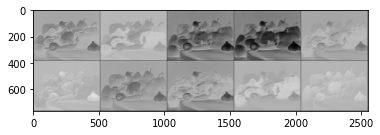

In [15]:
# Visualize the output y
def vis_features(y):
    # Organize it into 10 grayscale images
    out = y.permute(1, 0, 2, 3)
    # Scale between [0, 1]
    out = (out - out.min().expand(out.size())) / (out.max() - out.min()).expand(
        out.size()
    )
    # Create a grid of images
    out = torchvision.utils.make_grid(out, nrow=5)
    # Convert to numpy image
    out = np.transpose(out.detach().numpy(), (1, 2, 0))
    # Show
    plt.imshow(out)
    # Remove grid
    plt.gca().grid(False)


vis_features(y)


So far filters preserve the resolution of the input feature map. However, it is often useful to _downsample the output_. This can be obtained by using the `stride` option in `torch.nn.Conv2d`:


torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 24, 32])


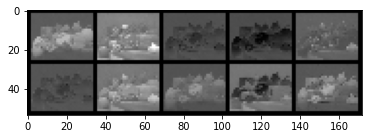

In [16]:
# Try again, downsampling the output
conv_ds = torch.nn.Conv2d(3, 10, kernel_size=5, stride=16, padding=0, bias=False)
y_ds = conv_ds(x)
print(x.size())
print(y_ds.size())
vis_features(y_ds)


Applying a filter to an image or feature map interacts with the boundaries, making the output map smaller by an amount proportional to the size of the filters. If this is undesirable, then the input array can be padded with zeros by using the `pad` option:


torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 384, 512])


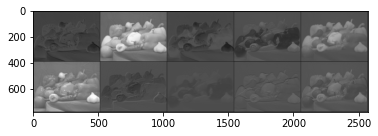

In [17]:
# Try padding
conv_pad = torch.nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2, bias=False)
y_pad = conv_pad(x)
print(x.size())
print(y_pad.size())
vis_features(y_pad)


In order to consolidate what has been learned so far, we will now design a filter by hand:


torch.Size([1, 3, 384, 512])
torch.Size([1, 1, 384, 512])


Text(0.5, 1.0, '- abs(filter output)')

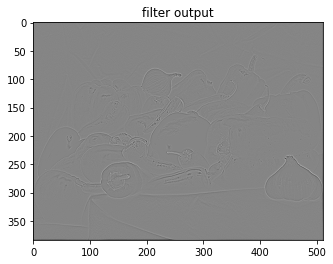

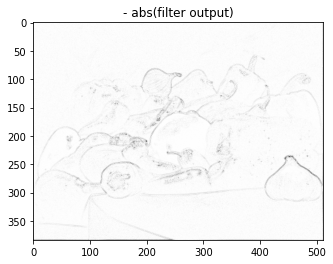

In [18]:
w = torch.FloatTensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
w = w.repeat(3, 1).reshape(1, 3, 3, 3)
conv_lap = torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, bias=False)
conv_lap.weight = torch.nn.Parameter(w)
y_lap = conv_lap(x)
print(x.size())
print(y_lap.size())

plt.figure()
vis_features(y_lap)
plt.title("filter output")

plt.figure()
vis_features(-torch.abs(y_lap))
plt.title("- abs(filter output)")


### :: TASK 2.1 ::

- i. What filter have we implemented?
- ii. How are the RGB colour channels processed by this filter?
- iii. What image structure are detected?


######################

- i. This filter is a derivative filter. Indeed, it detect the horizontal and vertical edges. The relative intensity of the edges can be finetuned with the value of the center pixel (currently 4). To be exact, this corresponds to the **Laplacian filter** which approximates a second derivative measure on the image.
- ii. The RGB colour channels are all considered equally, in this case, with the function `.repeat()`. In this case, the Laplacian filter is applied to each channel at once, independently. The output is then the average of the Laplacian filter applied to the channels.
- iii. This filter highlights the area with high changes. On the contrary, it will flatten the homogeneous areas. Thus, this filter will detect the edges.

######################


## Non-linear activation functions

The simplest non-linearity is obtained by following a linear filter by a _non-linear activation function_, applied identically to each component (i.e. point-wise) of a feature map. The simplest such function is the _Rectified Linear Unit (ReLU)_

$$
  y_{ijk} = \max\{0, x_{ijk}\}.
$$

This function is implemented by [`torch.nn.ReLU()`](https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU). Run the code below and understand what the filter $\mathbf{w}$ is doing.


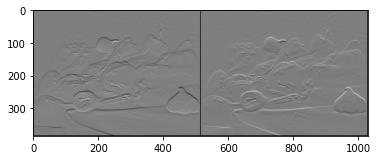

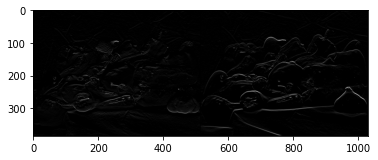

In [19]:
w = torch.FloatTensor([[1], [0], [-1]]).repeat(1, 3, 1, 1)
w = torch.cat((w, -w), 0)

conv = torch.nn.Conv2d(3, 2, kernel_size=(3, 1), stride=1, padding=0, bias=False)
conv.weight = torch.nn.Parameter(w)
relu = torch.nn.ReLU()

y = conv(x)
z = relu(y)

plt.figure()
vis_features(y)
plt.figure()
vis_features(z)


## Pooling

There are several other important operators in a CNN. One of them is _pooling_. A pooling operator operates on individual feature channels, coalescing nearby feature values into one by the application of a suitable operator. Common choices include max-pooling (using the max operator) or sum-pooling (using summation). For example, _max-pooling_ is defined as:

$$
   y_{ijk} = \max \{ y_{i'j'k} : i \leq i' < i+p, j \leq j' < j + p \}
$$

Max-pooling is implemented by [`torch.nn.MaxPool2d()`](https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d).

### :: TASK 2.2 ::

Run the code below to try max-pooling. Look at the resulting image. Can you interpret the result?


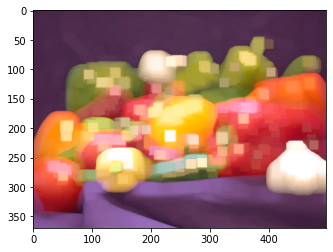

In [20]:
mp = torch.nn.MaxPool2d(15, stride=1)
y = mp(x)
plt.imshow(y.squeeze().permute(1, 2, 0).numpy())
plt.gca().grid(False)


######################

We can see that this image is has much more blur than the original image. Indeed, each patch of pixel of size $15 \times 15$ is replaced with its maximum value.

Moreover, the image is much brighter, because we use the maximum operator. On the contrary, the image would be much darker with a minimum operator.
We also notice that the purple curtain has almost no changes. Indeed, this is an homogeneous. All pixels in a patch have almost the same value. Thus, the max-pooling operator doesn't change the pixel in this area.

######################


# Part 3 - Training a CNN

This part is an introduction to using PyTorch for training simple neural net models. CIFAR-10 dataset will be used.


## Imports


In [21]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable


## Parameters


The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook.
Unless otherwise specified, use the default values throughout this assignment.


In [22]:
batch_size = 64  # input batch size for training
epochs = 10  # number of epochs to train
lr = 0.01  # learning rate


## Warmup


It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).
The train/test split is 50k/10k.


In [33]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time,
#          because it will download the dataset from the internet
dataset = "cifar10"
data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
trainset = datasets.CIFAR10(
    root=".", train=True, download=True, transform=data_transform
)
testset = datasets.CIFAR10(
    root=".", train=False, download=True, transform=data_transform
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=0
)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=0
)


Files already downloaded and verified


AttributeError: ignored

### :: TASK 3.1 ::

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images. Display 5 images from the dataset together with their category label. [See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.


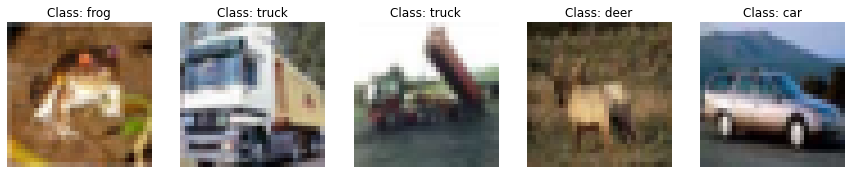

In [24]:
##########################
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

dataiter = iter(trainset)
for i in range(5):
    image, label = next(dataiter)
    image = image / 2 + 0.5  # unnormalize
    axes[i].imshow(np.transpose(image.numpy(), (1, 2, 0)))
    axes[i].set_title(f"Class: {classes[label]}")
    axes[i].axis("off")


plt.gca().grid(False)
plt.show()
##########################


## Training a Convolutional Network on CIFAR-10


Start by running the provided training code below. By default it will train on CIFAR-10 for 10 epochs (passes through the training data) with a single layer network. The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`. Note the decrease in training loss and corresponding decrease in validation errors.


In [43]:
def train(epoch, network):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data.to(device))
        loss = F.cross_entropy(output, target.to(device))
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )


def test(network):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = network(data.to(device))
        test_loss += F.cross_entropy(
            output, target.to(device), size_average=False
        ).item()  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[
            1
        ]  # get the index of the max log-probability
        correct += pred.eq(target.to(device).data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )


In [44]:
# Single layer network architecture


class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        self.num_inputs = num_inputs

    def forward(self, input):
        input = input.view(-1, self.num_inputs)  # reshape input to batch x num_inputs
        output = self.linear(input)
        return output


In [46]:
# Train
network = Net(3072, 10).to(device)
optimizer = optim.SGD(network.parameters(), lr=lr)
for epoch in range(1, 11):
    train(epoch, network)
    test(network)


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.283309
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.974971
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.685779
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.721574
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.805979
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.840387
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.678157
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.745436

Test set: Average loss: 1.7822, Accuracy: 3825/10000 (38%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.864596
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.643385
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.691632
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.670930
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.876323
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.724403
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.863534
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.650045

Test set: Average loss: 1.7501, Accuracy: 3956/10000 (40%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.517063
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.787

### :: TASK 3.2 ::

Add code to create a convolutional network architecture as below.

- Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
- 2 by 2 max pooling.
- Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
- 2 by 2 max pooling.
- Flatten to vector.
- Linear layer with 64 hidden units + Tanh nonlinearity.
- Linear layer to 10 output units.


In [47]:
##########################

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=0, bias=True),
            nn.Tanh(),
            torch.nn.MaxPool2d(2, stride=1),
            nn.Conv2d(16, 128, kernel_size=5, stride=1, padding=0, bias=True),
            nn.Tanh(),
            torch.nn.MaxPool2d(2, stride=1),
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(64, bias=True),
            nn.Tanh(),
            nn.Linear(64, 10, bias=True),
        )

    def forward(self, input):
        x = self.conv(input)
        output = self.linear(x)
        return output
        
##########################

### :: TASK 3.3 ::

Some of the functions in a CNN must be non-linear. Why?


######################

The CNN models is made of different blocks. Each of those blocks must contain non-linear layers, like activation function and maxpooling function.
Indeed, all the other layers are linear while the problem is not. The model can solve more complex problems with such non linearities.

######################


### :: TASK 3.4 ::

Train the CNN for 20 epochs on the CIFAR-10 training set.


In [48]:
# Train
network = ConvNet().to(device)
optimizer = optim.SGD(network.parameters(), lr=lr)
for epoch in range(1, 21):
    train(epoch, network)
    test(network)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.335966
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.886787
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.762883
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.793967
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.796821
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.745697
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.713566
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.787415

Test set: Average loss: 1.5389, Accuracy: 4482/10000 (45%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.625241
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.533901
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.285255
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.389874
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.206709
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.512459
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.346351
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.340289

Test set: Average loss: 1.5293, Accuracy: 4696/10000 (47%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.339015
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.116

We improved our result by more than 20% !


### :: TASK 3.5 ::

Plot the first convolutional layer weights as images after the last epoch. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )


Weights shape: torch.Size([16, 3, 5, 5])


Text(0.5, 1.0, 'First 16 features')

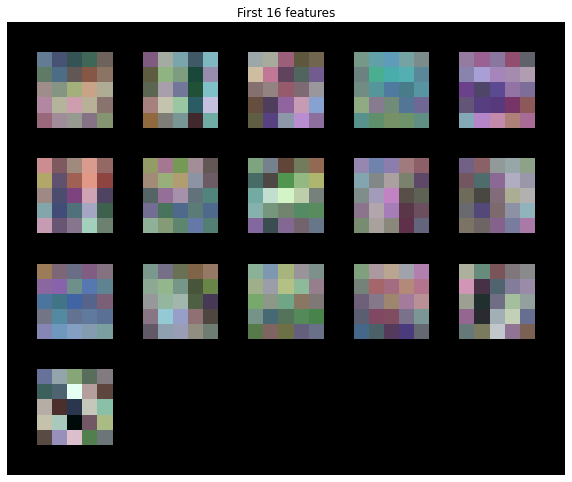

In [51]:
##########################
# Note: I introduced bias in every layer, but of course, I am not plotting it
weights = list(network.conv[0].parameters())[0].data
print(f"Weights shape: {weights.shape}")

weights = (weights - weights.min().expand(weights.size())) / (weights.max() - weights.min()).expand(
    weights.size()
)
grid = torchvision.utils.make_grid(weights, nrow=5)
grid = np.transpose(grid.detach().cpu().numpy(), (1, 2, 0))
fig = plt.figure(figsize=(10, 10))
plt.imshow(grid)
plt.gca().grid(False)
plt.axis("off")
plt.title(f"First {len(weights)} features")
##########################


### :: TASK 3.6 ::

What is the dimensionality of the weights at each layer? How many parameters are there in total in this CNN architecture?


######################

Let's count the parameters at every layer:

- The first convolutional layers has 16 output filters of size $5 \times 5$, from 3 input filters.
  - the weight has dimension $16 \times 3 \times 5 \times 5$.
  - the bias has dimension $16$.
- The second convolutional layers has 128 output filters of size $5 \times 5$, from 16 input filters.
  _ the weight has dimension $128 \times 16 \times 5 \times 5$.
  _ the bias has dimension $128$.
  The convolutional block has 52 544 parameters.

To compute the size of the linear layers, let's compute the size of the ouput from the convolutional block.

As given by Pytorch (see https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), the output size of the first convolutional layer is

\begin{align}
H & = \frac{32 +2\times 0- 1\times(5-1) -1}{1} +1& = 28\\
W & = \frac{32 +2\times 0- 1\times(5-1) -1}{1} +1& = 28\\
\end{align}

As given by Pytorch (see https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), the output size of the first max pool layer is

\begin{align}
H & = \frac{27 - (2-1) -1}{1} +1& = 27\\
W & = \frac{27 - (2-1) -1}{1} +1& = 27\\
\end{align}

If we repeat that logic on the second convolutional block, we conclude that the output of the convolutionnal block has size $[128, 22, 22]$. So we can compute the number of parameters on the linear block.

- The first linear layer outputs 64 neurons.

  - the weight has dimension $128 \times 22 \times 22 \times 64$.
  - the bias has dimension $64$.

- The first linear layer outputs 2 neurons.
  - the weight has dimension $64 \times 10$.
  - the bias has dimension $10$.

The linear block has 3 965 642 parameters.

In total, the model has 4 018 186 parameters. The next cell verifies that value.

######################


In [52]:
number_parameters = 0
for parameter in network.parameters():
    number_parameters += np.sum(np.ones(parameter.shape))
print(f"Number of parameters in the model:", int(number_parameters))

Number of parameters in the model: 4018186


## Useful resources

- [PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py)
- [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)


## AUTHORSHIP STATEMENT

I declare that the preceding work was the sole result of my own effort and that I have not used any code or results from third-parties.

Matias Etcheverry
